In [1]:
import pandas as pd
import numpy as np
import json
import re
from plotnine import *
import plotnine


%matplotlib inline
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumBarunGothic'
plt.rcParams["font.size"] = 20
plt.rcParams["figure.figsize"] = (15,8)


# pandas max row 
pd.options.display.max_rows = 3000

## 01. 데이터셋팅

- PNU 코드로 통일

### 1. 전유부

- PNU 코드 추가
- apt 추출
- 건물별 면적별 세대로 그룹화

In [2]:
# 전유부 데이터
b_unit = pd.read_csv('data/전유부.csv', dtype={
    '건물명':object, 
    '시군구코드': object, 
    '법정동코드' : object, 
    '층번호': np.int64, 
    '번' : object, 
    '지' : object, 
    '층구분코드': object 
    }
)

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
# 전유부 데이터 PNU 추가
b_unit['번'] = b_unit['번'].astype(str).str.zfill(4)
b_unit['지'] = b_unit['지'].astype(str).str.zfill(4)

b_unit['동'] = b_unit['대지주소'].str.replace('세종특별자치시 ',"")
b_unit['동'] = b_unit['동'].str.split(' ').str[1]
b_unit['지번'] = b_unit['번'] + b_unit['지']
b_unit['PNU'] = b_unit['동'] + b_unit['번'] + b_unit['지']
b_unit.head()

,대지주소,시군구코드,법정동코드,동명칭,호명칭,층구분코드,층번호,면적(전용면적),건물명,번,지,용도코드명,주용도코드,기타용도,동,지번,PNU
0,세종특별자치시 반곡동 4121-1002번지,36110,10100,주건축물제1동,101,20,1,3.2402,세종펠리스,4121,1002,일반음식점,4001,"일반음식점(기계,전기실)",반곡동,41211002,반곡동41211002
1,세종특별자치시 반곡동 4121-1002번지,36110,10100,주건축물제1동,101,20,1,39.3700,세종펠리스,4121,1002,일반음식점,4001,제2종근생(일반음식점),반곡동,41211002,반곡동41211002
2,세종특별자치시 반곡동 4121-1002번지,36110,10100,주건축물제1동,101,20,1,10.3346,세종펠리스,4121,1002,일반음식점,4001,"일반음식점(계단실,복도등)",반곡동,41211002,반곡동41211002
3,세종특별자치시 반곡동 4121-1002번지,36110,10100,주건축물제1동,101,20,1,33.6765,세종펠리스,4121,1002,일반음식점,4001,일반음식점(주차장),반곡동,41211002,반곡동41211002
4,세종특별자치시 반곡동 4121-1002번지,36110,10100,주건축물제1동,102,20,1,48.9500,세종펠리스,4121,1002,일반음식점,4001,제2종근생(일반음식점),반곡동,41211002,반곡동41211002


<AxesSubplot:>

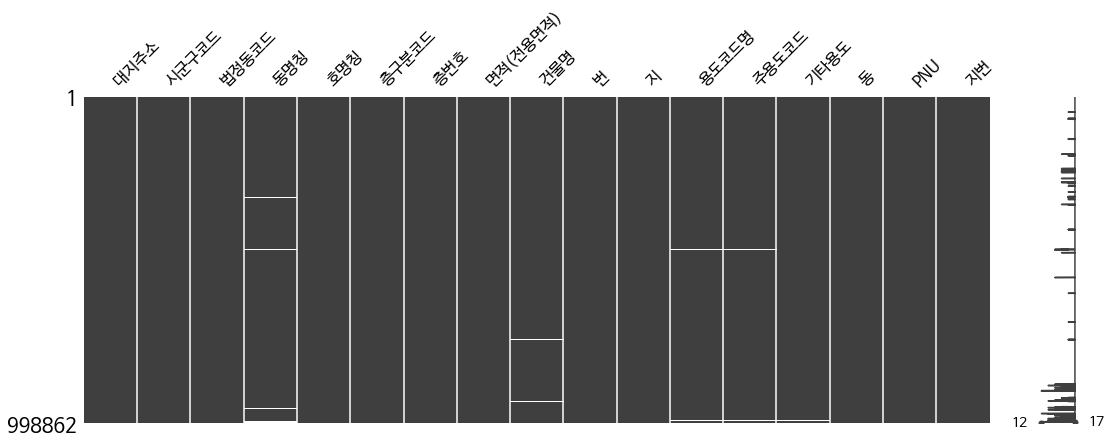

In [50]:
# 결측치 보기
import missingno as msno
msno.matrix(b_unit, figsize=(18,6))

In [4]:
apt_unit = b_unit[b_unit['기타용도'].str.contains('아파트',na=False)]
apt_unit['기타용도'].unique()

array(['아파트', '공동주택(아파트)', '아파트 지하계단실', '아파트(도시형생활주택)',
       '아파트(도시형생활주택-원룸형)', '공둥주택(아파트)', '지하주차장,아파트동출입구', '사원아파트',
       '노인정(아파트)', '아파트 상가동', '아파트  상가동', '재동아파트상가', '아파트상가', '아파트상가내'],
      dtype=object)

In [5]:
#아파트 비해당 정보 제외
non_apt = ['지하','주차장','상가','노인정']
pattern = '|'.join(non_apt)
apt_unit = apt_unit.loc[~apt_unit['기타용도'].str.contains(pattern, case = False)]
apt_unit['기타용도'].unique()

array(['아파트', '공동주택(아파트)', '아파트(도시형생활주택)', '아파트(도시형생활주택-원룸형)',
       '공둥주택(아파트)', '사원아파트'], dtype=object)

In [6]:
#건물별 면적으로 groupping(1231)
apt_unit['면적(전용면적)'] = np.trunc(apt_unit['면적(전용면적)']).astype(float)
apt_group = apt_unit.groupby(['대지주소','면적(전용면적)']).agg({'동명칭' : 'count','건물명' : 'first','PNU' : 'first','지번' : 'first','법정동코드' : 'first',})
apt_group = apt_group.reset_index(level=[0,1])
apt_group['동'] = apt_group['대지주소'].str.replace('세종특별자치시 ',"")
apt_group['동'] = apt_group['동'].str.split(' ').str[1]
apt_group.head()

,대지주소,면적(전용면적),동명칭,건물명,PNU,지번,법정동코드,동
0,세종특별자치시 고운동 1386번지,59.0,508,가락마을17단지,고운동13860000,13860000,11200,고운동
1,세종특별자치시 고운동 1387번지,84.0,263,가락마을22단지,고운동13870000,13870000,11200,고운동
2,세종특별자치시 고운동 1387번지,96.0,177,가락마을22단지,고운동13870000,13870000,11200,고운동
3,세종특별자치시 고운동 1390번지,84.0,268,가락마을21단지,고운동13900000,13900000,11200,고운동
4,세종특별자치시 고운동 1390번지,99.0,138,가락마을21단지,고운동13900000,13900000,11200,고운동


In [7]:
apt_group[apt_group['건물명'].isnull()]

,대지주소,면적(전용면적),동명칭,건물명,PNU,지번,법정동코드,동
523,세종특별자치시 조치원읍 번암리 66-14번지,54.0,1,NaN,조치원읍00660014,00660014,25031,조치원읍
524,세종특별자치시 조치원읍 번암리 66-14번지,59.0,3,NaN,조치원읍00660014,00660014,25031,조치원읍
525,세종특별자치시 조치원읍 번암리 66-14번지,68.0,1,NaN,조치원읍00660014,00660014,25031,조치원읍
526,세종특별자치시 조치원읍 번암리 66-14번지,71.0,1,NaN,조치원읍00660014,00660014,25031,조치원읍
527,세종특별자치시 조치원읍 번암리 66-14번지,72.0,6,NaN,조치원읍00660014,00660014,25031,조치원읍
528,세종특별자치시 조치원읍 번암리 66-14번지,73.0,8,NaN,조치원읍00660014,00660014,25031,조치원읍
529,세종특별자치시 조치원읍 번암리 66-14번지,79.0,5,NaN,조치원읍00660014,00660014,25031,조치원읍
582,세종특별자치시 조치원읍 정리 105-14번지,84.0,1,NaN,조치원읍01050014,01050014,25025,조치원읍
583,세종특별자치시 조치원읍 정리 59-1번지,59.0,22,NaN,조치원읍00590001,00590001,25025,조치원읍
594,세종특별자치시 조치원읍 죽림리 208-2번지,58.0,0,NaN,조치원읍02080002,02080002,25030,조치원읍


In [516]:
#이름변경
#apt_unit['건물명'] = apt_unit['건물명'].astype(str).str.replace('금남두진리버빌아파트','두진리버빌아파트')

### 2. apt 실거래 자료

- PNU 코드 추가
- apt 추출
- 건물별 면적별 세대로 그룹화

In [8]:
# 실거래 데이터
apt_trd = pd.read_csv('data/apt_trd.csv')
apt_trd['거래금액'] = apt_trd['거래금액'].str.replace(',','').astype(float)
apt_trd['아파트'] =apt_trd['아파트'].str.replace(' ','').astype(str)
apt_trd['전용면적'] = np.trunc(apt_trd['전용면적'])
apt_trd['월'] = apt_trd['월'].astype(str).str.zfill(2)
apt_trd['일'] = apt_trd['일'].astype(str).str.zfill(2)

apt_trd['계약일자'] = apt_trd['년'].astype(str) + apt_trd['월'] + apt_trd['일']
apt_trd['계약일자'] = pd.to_datetime(apt_trd['계약일자'], format='%Y%m%d')

apt_trd.head()

,Unnamed: 0,거래금액,건축년도,년,법정동,아파트,월,일,전용면적,지번,지역코드,층,해제사유발생일,해제여부,계약일자
0,0,36400.0,2016,2017,소담동,새샘마을9단지(중흥S클래스리버뷰),01,10,84.0,521,36110,5,NaN,NaN,2017-01-10
1,1,39282.0,2016,2017,소담동,새샘마을9단지(중흥S클래스리버뷰),01,20,84.0,521,36110,24,NaN,NaN,2017-01-20
2,2,49000.0,2016,2017,소담동,새샘마을3단지(모아미래도리버시티),01,21,97.0,BL-M3,36110,13,NaN,NaN,2017-01-21
3,3,40800.0,2016,2017,소담동,새샘마을3단지(모아미래도리버시티),01,25,97.0,BL-M3,36110,7,NaN,NaN,2017-01-25
4,4,8600.0,2016,2017,보람동,스타힐타워Ⅰ,01,01,16.0,743,36110,7,NaN,NaN,2017-01-01


In [9]:
# 지번 아닌 값 찾기
apt_trd['지번'].unique()

array(['521', 'BL-M3', '743', '947', '974', '939', '971', '976', '714',
       '750', '712', '759', '732', '649', '603', '548', '683', '690',
       '652', '656', '654', '679', '640', '1706', '1393', '1400', '1386',
       '1390', '1395', '1408', '1708', '1401', '1284', '1277', '1282',
       '1356', '1339', '1276', '1297', '858', '627', '633', '853', '681',
       '664', '855', '859', '666', '685', '456', '89', '398', '399',
       '393', '396', '72', '92', '75-2', '542', '35-3', '244-1', '133-10',
       '255', '970-3', '976-2', '401-48', '263', '320', '259-1', '268',
       '622', '197-16', '586', '715', '751', '775', '613', '697', '1703',
       '1705', '1409', '1279', '641', '636', '638', '651', '12-1', '11-1',
       '140', '167', '21-2', '389', '213-28', '528', '713', '763', '748',
       '845', '498-7', '121-6', '35-1', '739', '1396', '639', '346',
       '598', '700-1', '1387', '121', '605', '561', '593', '614', '558',
       '744', '653', '777', '764', '599', '597', '611', '3

In [10]:
# BL값, 가- 번지로 교체
apt_trd['지번'] = apt_trd['지번'].replace('BL-M3', 550)
apt_trd['지번'] = apt_trd['지번'].replace('BL H1', 738)
apt_trd['지번'] = apt_trd['지번'].replace('가-4102-1', '35-5')
apt_trd['지번'] = apt_trd['지번'].replace('가-4102-3', '59-7')
apt_trd['지번'] = apt_trd['지번'].replace('가-4101-2', '393-1')
apt_trd['지번'] = apt_trd['지번'].replace('가-4101-4', '143-1')
apt_trd['지번'] = apt_trd['지번'].replace('가-4121-2002', '771-87')
apt_trd['지번'] = apt_trd['지번'].replace('가-', 946)

In [11]:
#PNU코드 생성
apt_trd['번'] = apt_trd['지번'].astype(str).str.split('-').str[0]
apt_trd['지'] = apt_trd['지번'].astype(str).str.split('-').str[1]
apt_trd['번'] = apt_trd['번'].fillna(0)
apt_trd['지'] = apt_trd['지'].fillna(0)
apt_trd['번'] = apt_trd['번'].astype(str).str.zfill(4)
apt_trd['지'] = apt_trd['지'].astype(str).str.zfill(4)
apt_trd['PNU'] = apt_trd['법정동'].astype(str) + apt_trd['번'] + apt_trd['지']
apt_trd.head()

,Unnamed: 0,거래금액,건축년도,년,법정동,아파트,월,일,전용면적,지번,지역코드,층,해제사유발생일,해제여부,계약일자,번,지,PNU
0,0,36400.0,2016,2017,소담동,새샘마을9단지(중흥S클래스리버뷰),01,10,84.0,521,36110,5,NaN,NaN,2017-01-10,0521,0000,소담동05210000
1,1,39282.0,2016,2017,소담동,새샘마을9단지(중흥S클래스리버뷰),01,20,84.0,521,36110,24,NaN,NaN,2017-01-20,0521,0000,소담동05210000
2,2,49000.0,2016,2017,소담동,새샘마을3단지(모아미래도리버시티),01,21,97.0,550,36110,13,NaN,NaN,2017-01-21,0550,0000,소담동05500000
3,3,40800.0,2016,2017,소담동,새샘마을3단지(모아미래도리버시티),01,25,97.0,550,36110,7,NaN,NaN,2017-01-25,0550,0000,소담동05500000
4,4,8600.0,2016,2017,보람동,스타힐타워Ⅰ,01,01,16.0,743,36110,7,NaN,NaN,2017-01-01,0743,0000,보람동07430000


In [45]:
#PNU기준으로 건물명 통일하기
PUN_col = ['PNU','아파트','번','지']
PNU = apt_trd[PUN_col].drop_duplicates()
PNU = PNU.set_index('PNU')
PNU = PNU.transpose()

PNU = PNU.to_dict()
s = apt_trd[apt_trd['아파트'] == '해밀마을2단지']['PNU'].iloc[0]
PNU.get('금남면03200000')

In [44]:
# 건물명, PNU 정보 통일
for i in apt_group.index :
    
    pnu_value = apt_group['PNU'].iloc[i]
    #건물명, 지번 거래정보 기준으로 교체(단, 거래가 발생한 케이스만)
    #(1). PNU 정보 기준으로 건물명 바꾸기(group의 번지가 있는 케이스)
    if pnu_value in PNU :
        apt_group['건물명'].iloc[i] = PNU.get(pnu_value)['아파트']
    #(2). 건물명 정보 기준으로 PNU 정보 바꾸기(group의 번지가 누락된 케이스)
    else :
        bid_error = apt_group['건물명'].iloc[i]
        bid = apt_trd[apt_trd['아파트'].str.contains(bid_error)].iloc[0] if len(apt_trd[apt_trd['아파트'].str.contains(bid_error)]) != 0 else print(pnu_value)
        #apt_group['PNU'].iloc[i] = bid['PNU']
        #apt_group['지번'].iloc[i] =bid['번'] + bid['지']
    

apt_group.tail()

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


금남면03200000
금남면03200000
나성동00000000
나성동00000000
나성동00000000
나성동00000000
다정동00000000
다정동00000000
다정동00000000
다정동00000000
다정동00000000
다정동00000000
대평동07000000
대평동07000000
대평동07070000
대평동07070000
대평동07070000
대평동07070000
대평동07070000
대평동07070000
대평동07070000
대평동07070000
도담동08480000
도담동08480000
도담동08480000
도담동08480000
도담동08490000
도담동08490000
도담동08490000
도담동08510000
도담동08510000
도담동08510000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동00000000
반곡동0

TypeError: first argument must be string or compiled pattern

In [566]:
list_mean = []
list_count = []

for i in apt_group.index :
    area = apt_group['면적(전용면적)'].loc[i]
    bid = apt_group['건물명'].loc[i]

    sample = apt_trd[apt_trd['전용면적'] == area]
    sample = sample[sample['아파트'].astype(str).str.contains(bid)]
    sample = sample.sort_values('계약일자', ascending = False)

    count_5 = sample.head(5)['거래금액'].count()
    mean_5 = sample.head(5)['거래금액'].mean()

    list_mean.append(mean_5)
    list_count.append(count_5)


apt_group['최근5건'] = list_mean
apt_group['최근5건수'] = list_count

C:\Anaconda\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Anaconda\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Anaconda\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Anaconda\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Anaconda\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Anaconda\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Anaconda\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actual

In [567]:
final = apt_group[~apt_group['최근5건'].isnull()]
final.tail()

,대지주소,면적(전용면적),동명칭,건물명,PNU,법정동코드,동,최근5건,최근5건수
710,세종특별자치시 해밀동 블록 행정중심복합도시 6-4 생활권지구 L1블록,59.0,930,해밀마을1단지,해밀동00000000,11600,해밀동,41670.000000,4
711,세종특별자치시 해밀동 블록 행정중심복합도시 6-4 생활권지구 L1블록,84.0,780,해밀마을1단지,해밀동00000000,11600,해밀동,84340.000000,5
713,세종특별자치시 해밀동 블록 행정중심복합도시 6-4 생활권지구 L1블록,120.0,100,해밀마을1단지,해밀동00000000,11600,해밀동,80000.000000,1
728,세종특별자치시 해밀동 블록 행정중심복합도시 6-4생활권지구 M1블록블록,84.0,561,해밀마을2단지,해밀동00000000,11600,해밀동,72200.000000,5
729,세종특별자치시 해밀동 블록 행정중심복합도시 6-4생활권지구 M1블록블록,102.0,234,해밀마을2단지,해밀동00000000,11600,해밀동,108333.333333,3


## 아파트 기타용도텍스트 카운팅

In [57]:
# 아파트 추출
apt_unit = b_unit[b_unit['용도코드명']=='아파트']

list_pur = apt_unit['기타용도'].str.split('(').str[0]
list_pur = list_pur.tolist()

list_pur01 = []
for i in list_pur:
    a = i.split(',')
    if len(a) == 1 :
        list_pur01.append(a[0])
    else :
        for i in range(len(a)) :
            list_pur01.append(a[i])


In [81]:
list_pur02 = pd.Series(list_pur01)
result = list_pur02.value_counts().head(5)
result

계단실      97471
아파트      92046
벽체       76238
지하주차장    59329
승강기      59102
dtype: int64